In [50]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from scipy.spatial import ConvexHull
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql import Window
from pyspark.ml.feature import Normalizer
from pyspark.mllib.linalg.distributed import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from scipy.stats import *
from sklearn.cluster import KMeans, OPTICS, DBSCAN, cluster_optics_dbscan

import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
os.environ['ARROW_PRE_0_15_IPC_FORMAT']='1'


In [11]:
sc = SparkSession.builder.getOrCreate()
sc.conf.set("spark.sql.execution.arrow.enabled", "true")

In [12]:
test_data = datasets.make_blobs(
    n_samples = 14000, centers = 7, n_features = 2, cluster_std = [20,200,20,200,200,200,200], shuffle = False,
    random_state = 15, center_box=(500,3500))

df_agi = pd.DataFrame(test_data[0])
df_agi.columns = ['AGI','Refund']
df_agi['label'] = test_data[1]
df_agi['id'] = df_agi.index
df_agi["AGI"] = df_agi["AGI"] * 20

In [25]:
SAMPLE_AMOUNT = 500

samp_clust_01 = df_agi.sample(SAMPLE_AMOUNT)
samp_clust_02 = df_agi[((df_agi["label"] == 0) | (df_agi["label"] == 1))].sample(SAMPLE_AMOUNT)
samp_clust_03 = df_agi[((df_agi["label"] == 0) | (df_agi["label"] == 2))].sample(SAMPLE_AMOUNT)
samp_clust_04 = df_agi[((df_agi["label"] == 1) | (df_agi["label"] == 3) | (df_agi["label"] == 5))].sample(SAMPLE_AMOUNT)
samp_clusters = [samp_clust_01, samp_clust_02, samp_clust_03, samp_clust_04]

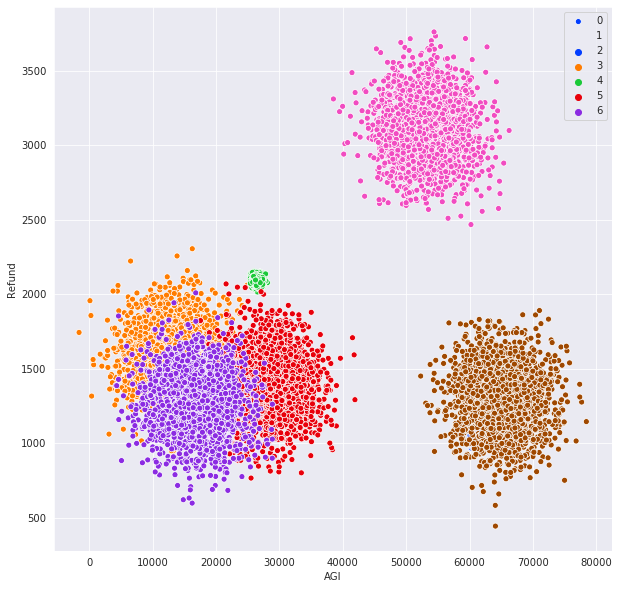

In [26]:
sns.set_style("darkgrid")

g = sns.scatterplot(x = df_agi.AGI, y = df_agi.Refund, hue = df_agi.label, palette='bright')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.legend(labels = ["0", "1", "2", "3", "4", "5", "6"])
plt.show()

In [27]:
def cluster_scaler(cluster, minmax = True):
    
    data = np.array(cluster.loc[:,['AGI','Refund']])
    
    if minmax:
        minmax = MinMaxScaler()
        return minmax.fit_transform(data)
    
    else:
        z_scale = StandardScaler()
        return z_scale.fit_transform(data)


In [28]:
minmaxed_samples = [cluster_scaler(cluster) for cluster in samp_clusters]

In [29]:
minmaxed_samples[0];

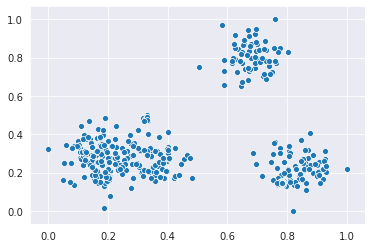

In [37]:
sns.scatterplot(minmaxed_samples[0][:,0],minmaxed_samples[0][:,1])

## Experimenting with local density based clustering (DBSCAN and OPTICS)

In [45]:
clust = OPTICS().fit(minmaxed_samples[0])

In [46]:
labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.5)
labels_010 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=.1)
labels_025 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.25)

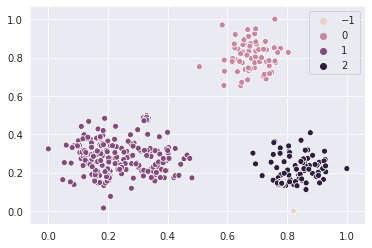

In [49]:
sns.scatterplot(minmaxed_samples[0][:,0],minmaxed_samples[0][:,1], hue=labels_010)

one option would be to run dbscan or optics, and then use the mean distance to each cluster centroid (or min or max) as metrics. 

## Experimenting With Kmeans and kmeans like methods
the idea here is to run kmeans with a series of numbers of clusters, then take the max silhouette ( or min db) score as the measurement of clustering

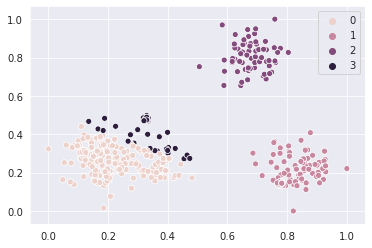

In [57]:
kmeans = KMeans(n_clusters= 4)
clusters = kmeans.fit_predict(minmaxed_samples[0])
sns.scatterplot(minmaxed_samples[0][:,0],minmaxed_samples[0][:,1], hue=clusters)

In [63]:
clusters.shape

(500,)

In [70]:
def kmeans_scores(samples, max_clusters=10, return_labels = False):
    db_scores = []
    sil_scores = []
    labels = []
    for i in range(2, max_clusters):
        kmeans = KMeans(n_clusters= i)
        clusters = kmeans.fit_predict(samples)
        db_score = davies_bouldin_score(minmaxed_samples[0], clusters)
        sil_score = silhouette_score(minmaxed_samples[0], clusters)
        db_scores.append(db_score)
        sil_scores.append(sil_score)
        if return_labels:
            labels.append(clusters)
    if return_labels:
        return db_scores, sil_scores, labels
    else:
        return db_scores, sil_scores

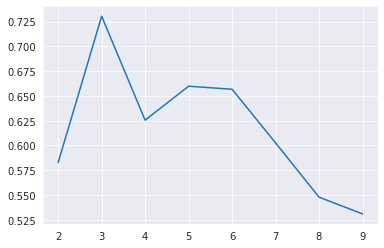

In [67]:
sns.lineplot(y=sil_scores, x=range(2,10))

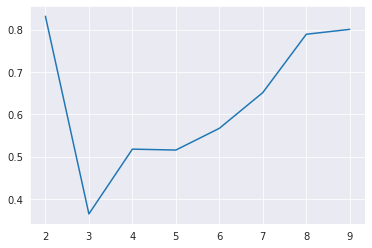

In [68]:
sns.lineplot(y=db_scores, x=range(2,10))